## Group 4: Numerical Classification of Heart Disease

### Group Members
- Jonathan Swanson
- Jack Schnair
- Zach Sabri
- Ishan Patel
- Vishal Patel

### Description:
This program uses various MLP models to conduct ensemble voting. 

### The steps are as follows:
- Load data
- Preprocess data
    - Normalize data
    - Stratify split into train/test
    - Oversample minority classes using SMOTE
- Visualize data before & after oversampling
- Define a function 'results' that prints the train test and validation results of a given model
- Create 5 models
- Conduct ensemble voting 
- Print results of a base MLP model, our models, and the ensemble voting

### Works Cited
- https://scikit-learn.org/stable/tutorial/index.html
- https://imbalanced-learn.org/stable/
- https://www.pluralsight.com/guides/validating-machine-learning-models-scikit-learn

### Required Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer

from sklearn.neural_network import MLPClassifier

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

import statistics
from statistics import mode
from imblearn.over_sampling import SMOTE

### Load data

In [2]:
# Read in CSV
df = pd.read_csv('heart.csv')
display(df.head())
display(df.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Preprocess data
- Set target
- Stratify
- Normalize
- Oversample

In [3]:
# Removes invalid results
df = df[df['thal'] > 0]

# Split data into features and target
y = df['thal']
x = df.drop(['target', 'thal'], axis=1)

# Get test and train split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

# Normalize our dataset without leaking test data
scaler = Normalizer()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Produces synthetic oversamples
sm = SMOTE(sampling_strategy='not majority')
xtrain, ytrain = sm.fit_resample(xtrain, ytrain)

### Graphs of data before and after oversampling

Text(0.5, 1.0, 'Diseaese type')

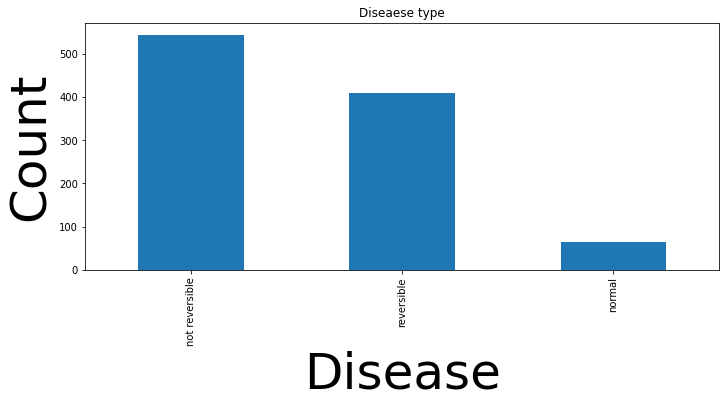

In [4]:
# Graph our initial dataset
fig = plt.figure(figsize=(25,10))

axis2 = fig.add_subplot(222)
df['thal'].value_counts().plot(kind='bar', ax=axis2)
diseaseTicks = ('not reversible', 'reversible', 'normal')

axis2.set_xticklabels(diseaseTicks)
axis2.set_xlabel('Disease', size = 50)
axis2.set_ylabel('Count', size = 50)
axis2.set_title('Diseaese type')

Text(0.5, 1.0, 'Oversample class count')

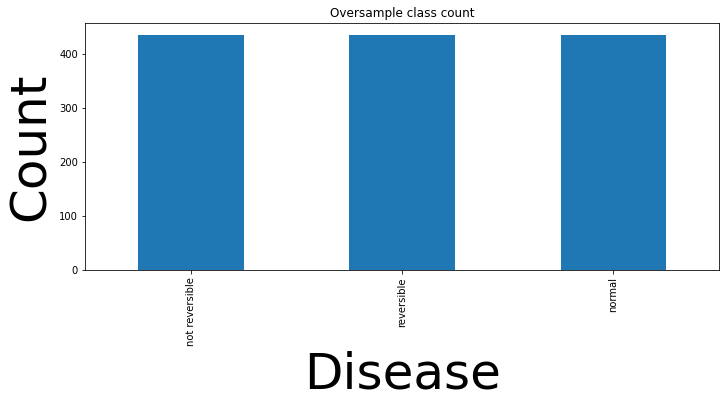

In [5]:
# Graph our data after oversampling minority classes
fig = plt.figure(figsize=(25,10))

axis2 = fig.add_subplot(222)
ytrain.value_counts().plot(kind='bar', ax=axis2)
diseaseTicks = ('not reversible', 'reversible', 'normal')

axis2.set_xticklabels(diseaseTicks)
axis2.set_xlabel('Disease', size = 50)
axis2.set_ylabel('Count', size = 50)
axis2.set_title('Oversample class count')

### A function that produces train, test and validate results for each model

In [6]:
def results(model):   
    # Train results
    train_res = model.predict(xtrain)
    train_acc = np.round(100*accuracy_score(ytrain, train_res), 2)
    
    # Test results
    model_res = model.predict(xtest)
    model_acc = np.round(100*accuracy_score(ytest, model_res), 2)
    
    # K-Fold Cross validation (src: https://www.pluralsight.com/guides/validating-machine-learning-models-scikit-learn)
    kfold = model_selection.KFold(n_splits=5)
    results_kfold = model_selection.cross_val_score(model, x, y, cv=kfold)
    validation_acc = np.round(100 * results_kfold.mean(), 2)
    
    print("Results for", model.__class__.__name__)
    print("\t Train Accuracy: ", train_acc)
    print("\t Test Accuracy: ", model_acc)
    print("\t Validation Accuracy: ", validation_acc)
    
    return (model_res, model_acc, validation_acc)

### Defined 6 Models
- A base model with no parameters / is not tunes
- One model per group member, each with custom parameters

In [7]:
# Create a fully connected ANN (MLP)
mlp1 = MLPClassifier()
mlp1.fit(xtrain, ytrain)

# Get the prediction
mlp1_predicted, mlp1_acc, mlp1_val = results(mlp1)

C:\Users\john\anaconda3\envs\hw5.2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Results for MLPClassifier
	 Train Accuracy:  57.32
	 Test Accuracy:  57.84
	 Validation Accuracy:  68.87


In [8]:
# Zach's model
zach_clf = MLPClassifier(hidden_layer_sizes=(100,350,35),
                         activation="relu",
                         solver = "adam",
                         learning_rate = "constant",
                         batch_size = 10,
                         max_iter = 300) # made more iterations. 

zach_clf.fit(xtrain,ytrain)
zach_pred, zach_model_acc, zach_val = results(zach_clf)

Results for MLPClassifier
	 Train Accuracy:  90.88
	 Test Accuracy:  78.92
	 Validation Accuracy:  93.61


In [9]:
# Create a fully connected ANN (MLP)
vishal_model = MLPClassifier(hidden_layer_sizes = (150, 125, 100), activation = 'relu',
                             max_iter = 350,
                             solver = 'adam',
                             random_state = 1)
vishal_model.fit(xtrain, ytrain)

# Get the prediction
vishal_patel_predicted, vishal_model_acc, vishal_model_val = results(vishal_model)

Results for MLPClassifier
	 Train Accuracy:  81.99
	 Test Accuracy:  75.0
	 Validation Accuracy:  63.25


In [10]:
# Ishan's model
ishan_model = MLPClassifier(hidden_layer_sizes=(500, 250, 125, 75, 50, 25, 10), 
                            activation='tanh',
                            max_iter=1000,
                            solver='adam',
                            random_state=1)
ishan_model.fit(xtrain, ytrain)

ishan_pred, ishan_acc, ishan_val = results(ishan_model)

Results for MLPClassifier
	 Train Accuracy:  98.77
	 Test Accuracy:  98.04
	 Validation Accuracy:  67.68


### Important Note: You can skip this cell, it takes a while to run (10-30 minutes)
- It uses grid search cv to produce optimal parameters
- The output changes from run to run, so I saved results that worked well for me

In [ ]:
# Jonathan's model

# List of parameters for the GridSearch to test/search
params = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [500, 1000, 2000]
}

# Base MLP that the grid search uses to test parameters
base_mlp = MLPClassifier()

# Use grid search to find the 'best' parameters for accuracy
gs = GridSearchCV(estimator=base_mlp, param_grid=params, cv=3, verbose=True)
gs.fit(xtrain, ytrain)

# The best parameters found
display(gs.bestparams)

In [31]:
# Jonathan's model continued 

# Previous best parameters
saved_best_params = {'activation': 'tanh', 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}

# Jonathan's MLP using GSCV results
jds_mlp = MLPClassifier(**saved_best_params, hidden_layer_sizes=(300, 200, 100, 50))
jds_mlp.fit(xtrain, ytrain)

jds_predicted, jds_acc, jds_val = results(jds_mlp)

Results for MLPClassifier
	 Train Accuracy:  98.62
	 Test Accuracy:  94.12
	 Validation Accuracy:  69.84


In [12]:
# Jack's model
jack_model = MLPClassifier(hidden_layer_sizes=(200,100,50),
                    activation = 'tanh',
                    solver = 'adam',
                    learning_rate = 'adaptive',
                    max_iter = 1000,
                )
jack_model.fit(xtrain, ytrain)

jack_predicted, jack_acc, jack_val = results(jack_model)

Results for MLPClassifier
	 Train Accuracy:  75.63
	 Test Accuracy:  70.59
	 Validation Accuracy:  72.5


### Helper functions for ensemble voting

In [13]:
# Combines arrays into a array of tuples, useful for voting
# combine_arrs([1, 2, 3], [4, 5, 6], [7, 8, 9]) ==> [(1, 4, 7), (2, 5, 8), (3, 6, 9)]
def combine_arrs(*args):
    arr_of_tuples = []
    for i in range(len(args[0])):
        arr_of_tuples.append(tuple([arr[i] for arr in args]))
    return arr_of_tuples

# Returns array of most common vote amongst the models
def ensemble_vote(votes_arr):
    conclusion = []
    for votes in votes_arr:
      try: # Pick the most common vote
        conclusion.append(mode(votes))
      except: # No mode, use most performant model, which is the first in the list (done manually)
        conclusion.append(votes[0])
      
    return conclusion

### Combine the votes of each model into an array of tuples
- The ith tuple contains the votes of the ith entry for all models

In [24]:
# Combines individual voting arrays into a single array of tuples, 
# where the ith tuple contains the guesses for the ith entry in xtest
ensemble_arr = combine_arrs(ishan_pred, jds_predicted, zach_pred, vishal_patel_predicted, jack_predicted)
print(ensemble_arr[:5])

[(2, 2, 2, 2, 2), (3, 3, 2, 2, 2), (2, 2, 2, 2, 2), (3, 3, 2, 2, 2), (3, 3, 3, 3, 3)]


### Case a vote
- Print some voting results vs actual results

In [25]:
# Determines the most common vote
res_from_vote = ensemble_vote(ensemble_arr)
acc_from_vote = np.round(100 * accuracy_score(ytest, res_from_vote), 2)
print(res_from_vote[:5])
print(list(ytrain[:5].values))

[2, 2, 2, 2, 3]
[3, 3, 2, 2, 3]


### Print the results of all models & the base model

In [26]:
# Print out all of our results
print("TEST ACCURACY RESULTS:\n")
print("Base MLP1 Model\t: ", mlp1_acc, '%\n')

print("Zach's Model\t: ", zach_model_acc, '%')
print("Vishal's Model\t: ", vishal_model_acc, '%')
print("Ishan's Model\t: ", ishan_acc, '%')
print("John's Model\t: ", jds_acc, '%')
print("Jack's Model\t: ", jack_acc, '%\n')

print("Accuracy after ensemble voting: ", acc_from_vote, '%')

TEST ACCURACY RESULTS:

Base MLP1 Model	:  57.84 %

Zach's Model	:  78.92 %
Vishal's Model	:  75.0 %
Ishan's Model	:  98.04 %
John's Model	:  93.63 %
Jack's Model	:  70.59 %

Accuracy after ensemble voting:  91.18 %


### Zach's keras model
- This didn't get used due to it conflicting with the sklearn models, but below is additional work he did in keras

In [ ]:
###################################################################################################################
#                Zach's cell
###################################################################################################################
'''
This was Zach's original model using keras, which ended up conflicting with the 
other group members work in sklearn. Its included here to give credit to the extra 
work he did in keras.

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
import keras

X = df.iloc[:,:12]
y = df.iloc[:,12]
X = X.to_numpy()
y = y.to_numpy()
for i in range(len(y)):
  if y[i]==1:
    y[i]=0
  elif y[i]==2:
    y[i]=1
  else:
    y[i]=2
code = LabelEncoder()
code.fit(y)
one_hot = code.fit_transform(y)
one_hot = np_utils.to_categorical(one_hot)
print(X)
print("-------------------------------------------------------------------------------------------------------------")
print(one_hot)



X_train, X_test, y_train, y_test = train_test_split(X,one_hot,test_size = .20, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)
print("-------------------------------------------------------------------------------------")
print(X_test)




count = []
normal = 64
unreversable = 544
reverseable = 410
count = np.array([normal,unreversable,reverseable])
count.sort()
median = np.median(count)

MSB_normal = median/normal
MSB_unreversable = median/unreversable
MSB_reversable = median/reverseable


print(f"The weight for normal is: {MSB_normal}")
print(f"The weight for unreversable is: {MSB_unreversable}")
print(f"The weight for reversable is: {MSB_reversable}")

weights = [MSB_normal,MSB_unreversable,MSB_reversable]
weights = np.array(weights)





zachs_model = keras.models.Sequential()
zachs_model.add(keras.layers.Dense(12,activation = "relu"))
zachs_model.add(keras.layers.Dense(100,activation = "relu"))
zachs_model.add(keras.layers.Dense(350,activation = "relu"))
zachs_model.add(keras.layers.Dense(35,activation = "relu"))
zachs_model.add(keras.layers.Dense(3,activation = "softmax"))

zachs_model.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

class_weight = {0:weights[0],1:weights[1],2:weights[2]}
history = zachs_model.fit(x = X_train,y = y_train,epochs = 35,batch_size = 10, class_weight = class_weight)


y_pred = zachs_model.predict(X_test)
y_pred_zach = y_pred.argmax(axis = 1)
y_test = y_test.argmax(axis = 1)

acc = accuracy_score(y_test,y_pred_zach)
print(f"The testing accuracy is : {acc}")'''